<a href="https://colab.research.google.com/github/shivamswarnkar/Image-Classifier/blob/master/MNIST_fashion_dropout_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# Download and load the data set
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Define and Train Model (without Dropout)

In [0]:
from torch import nn, optim
import torch.nn.functional as F


# Define Classifier Network 
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    
  def forward(self, x):
    
    # flatten x if input tensor is not flat
    x = x.view(x.shape[0], -1)
    
    # forward pass
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)
    
    return x

In [0]:
# setting up network
model = Classifier()

# hyper params
lr = 0.003
epochs = 30

# optimize and loss func
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
# trainning Network
train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  
  # train network
  for images, labels in trainloader:
    optimizer.zero_grad()
    loss = criterion(model(images), labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  
  # validate network
  
  with torch.no_grad():
    running_loss_validation = 0
    accuracy = 0
    for images, labels in testloader:
      log_ps = model(images)
      
      # loss
      running_loss_validation += criterion(log_ps, labels).item() 
      
      # accuracy
      ps = torch.exp(log_ps)
      _, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  train_losses.append(running_loss/len(trainloader))
  test_losses.append(running_loss_validation/len(testloader))
  print(f'Epoch {e+1}/{epochs}:\
  Test Accuracy:{100*accuracy/len(testloader):.3f}%\
  Train Loss:{running_loss/len(trainloader):.3f}\
  Test Loss:{running_loss_validation/len(testloader):.3f}')  

Epoch 1/30:  Test Accuracy:82.683%  Train Loss:0.517  Test Loss:0.476
Epoch 2/30:  Test Accuracy:85.768%  Train Loss:0.391  Test Loss:0.401
Epoch 3/30:  Test Accuracy:85.888%  Train Loss:0.359  Test Loss:0.387
Epoch 4/30:  Test Accuracy:86.783%  Train Loss:0.332  Test Loss:0.373
Epoch 5/30:  Test Accuracy:86.127%  Train Loss:0.319  Test Loss:0.383
Epoch 6/30:  Test Accuracy:86.953%  Train Loss:0.303  Test Loss:0.371
Epoch 7/30:  Test Accuracy:87.669%  Train Loss:0.293  Test Loss:0.356
Epoch 8/30:  Test Accuracy:88.037%  Train Loss:0.283  Test Loss:0.361
Epoch 9/30:  Test Accuracy:87.142%  Train Loss:0.281  Test Loss:0.370
Epoch 10/30:  Test Accuracy:87.550%  Train Loss:0.267  Test Loss:0.364
Epoch 11/30:  Test Accuracy:87.689%  Train Loss:0.261  Test Loss:0.365
Epoch 12/30:  Test Accuracy:87.291%  Train Loss:0.257  Test Loss:0.366
Epoch 13/30:  Test Accuracy:88.316%  Train Loss:0.246  Test Loss:0.350
Epoch 14/30:  Test Accuracy:87.619%  Train Loss:0.244  Test Loss:0.375
Epoch 15/30:  T

In [0]:
# plot loss
import matplotlib.pyplot as plt
%matplotlib inline

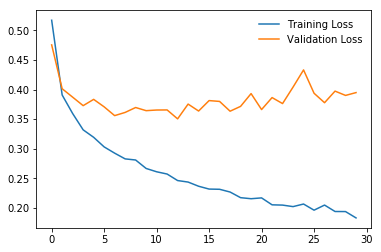

In [20]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)

# Fixing Overfitting (Dropout)

In [0]:
# define model
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    # define layers
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    
    # define layout
    self.dropout = nn.Dropout(p=0.2)
  
  def forward(self, x):
    # flatten input
    x = x.view(x.shape[0], -1)
    
    # forward pass
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    
    # output layer without dropout
    x = F.log_softmax(self.fc4(x), dim=1)
    
    return x

In [0]:
# setup network
model = Classifier()

# hyper params
epochs = 30
lr = 0.003

# setup loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [33]:
# training network
train_losses, test_losses = [], []

for e in range(epochs):
  train_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    loss = criterion(model(images), labels)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
  
  # turn off gradient
  with torch.no_grad():
    # turnoff dropout
    model.eval()
    
    test_loss = 0
    accuracy = 0
    # test all the images, add to test loss
    for images, labels in testloader:
      log_ps = model(images)
      test_loss += criterion(log_ps, labels)
      
      ps = torch.exp(log_ps)
      _, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      
      accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  # activate dropout
  model.train()
  
  # add loss to lists
  train_losses.append(train_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  
  # print this epoch's results
  print(f'Epoch {e+1}/{epochs}:\
  Train Loss:{train_losses[-1]:.3f}\
  Test Loss: {test_losses[-1]:.3f}\
  Accuracy:{100*accuracy/len(testloader):.3f}%')

Epoch 1/30:  Train Loss:0.600  Test Loss: 0.493  Accuracy:82.335%
Epoch 2/30:  Train Loss:0.482  Test Loss: 0.430  Accuracy:84.753%
Epoch 3/30:  Train Loss:0.449  Test Loss: 0.424  Accuracy:84.952%
Epoch 4/30:  Train Loss:0.436  Test Loss: 0.412  Accuracy:85.082%
Epoch 5/30:  Train Loss:0.423  Test Loss: 0.429  Accuracy:85.111%
Epoch 6/30:  Train Loss:0.410  Test Loss: 0.422  Accuracy:84.912%
Epoch 7/30:  Train Loss:0.400  Test Loss: 0.401  Accuracy:85.629%
Epoch 8/30:  Train Loss:0.403  Test Loss: 0.405  Accuracy:85.211%
Epoch 9/30:  Train Loss:0.393  Test Loss: 0.398  Accuracy:86.067%
Epoch 10/30:  Train Loss:0.394  Test Loss: 0.385  Accuracy:86.644%
Epoch 11/30:  Train Loss:0.386  Test Loss: 0.391  Accuracy:86.515%
Epoch 12/30:  Train Loss:0.383  Test Loss: 0.376  Accuracy:87.231%
Epoch 13/30:  Train Loss:0.374  Test Loss: 0.413  Accuracy:86.196%
Epoch 14/30:  Train Loss:0.377  Test Loss: 0.434  Accuracy:85.002%
Epoch 15/30:  Train Loss:0.370  Test Loss: 0.378  Accuracy:86.973%
Epoc

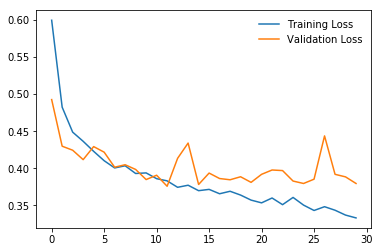

In [34]:
# plotting loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)

# Inference Model

Actual Class:6; Predicted Class:6


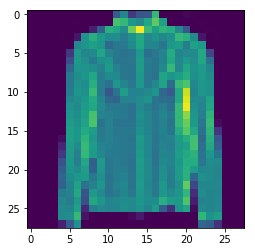

In [47]:
# sample test


# turn off dropout
model.eval()

# test data
data = iter(testloader)
images, labels = data.next() 
img = images[0]
label = labels[0]

# forward pass
ps = torch.exp(model(img))
top_ps, top_class = ps.topk(1, dim=1)

# plot or do whatever you want
plt.imshow(img.numpy().squeeze())
print(f'Actual Class:{label}; Predicted Class:{int(top_class)}')